In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet,self).__init__()
        self.conv1 = nn.Conv2d(1,32,3,1)
        self.conv2 = nn.Conv2d(32,64,3,1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12*12*64,128)
        self.fc2 = nn.Linear(128,10)

    def forward(self,x):
        x = self.conv1(x)
        x = f.relu(x)
        x = self.conv2(x)
        x = f.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(-1,12*12*64)
        x = self.fc1(x)
        x = f.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return f.log_softmax(x, dim=1)

from torchsummary import summary

model = MyNet()
print(model)
print(summary(model, (1, 28, 28)))

MyNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
         MaxPool2d-3           [-1, 64, 12, 12]               0
         Dropout2d-4           [-1, 64, 12, 12]               0
            Linear-5                  [-1, 128]       1,179,776
         Dropout2d-6                  [-1, 128]               0
            Linear-7                   [-1, 10]        

/Users/okuryuutasuku/Documents/MNIST/venv3.9.6/lib/python3.9/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [3]:
def load_MNIST(batch=128):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))])

    train_set = torchvision.datasets.MNIST(root="./data",
                                           train=True,
                                           download=True,
                                           transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch,
                                               shuffle=True,
                                               num_workers=2)

    val_set = torchvision.datasets.MNIST(root="./data",
                                         train=False,
                                         download=True,
                                         transform=transform)
    val_loader =torch.utils.data.DataLoader(val_set,
                                            batch_size=batch,
                                            shuffle=True,
                                            num_workers=2)

    return {"train":train_loader, "validation":val_loader}


In [5]:
# エポック数，バッジサイズ
epoch = 20
batch_size = 64
    
# 学習結果の保存
history = {
    "train_loss": [],
    "validation_loss": [],
    "validation_acc": []
}

# データのロード
data_loder = load_MNIST(batch=batch_size)

# GPUが使えるときは使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# ネットワーク構造の構築
net = MyNet().to(device)
print(net)

# 最適化方法の設定
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)


100.0%
100.0%
100.0%
100.0%

cpu
MyNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
for e in range(epoch):
    """ 学習部分 """
    loss = None
    train_loss = 0.0
    net.train() #学習モード
    print("\nTrain start")
    for i,(data,target) in enumerate(data_loder["train"]):
        data,target = data.to(device),target.to(device)

        #勾配の初期化
        optimizer.zero_grad()
        #順伝搬 -> 逆伝搬 -> 最適化
        output = net(data)
        loss = f.nll_loss(output,target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print("Training: {} epoch. {} iteration. Loss:{}".format(e+1,i+1,loss.item()))

    train_loss /= len(data_loder["train"])
    print("Training loss (ave.): {}".format(train_loss))
    history["train_loss"].append(train_loss)

    """検証部分"""
    print("\nValidation start")
    net.eval() #検証モード(Validation)
    val_loss = 0.0
    accuracy = 0.0

    with torch.no_grad():
        for data,target in data_loder["validation"]:
            data,target = data.to(device),target.to(device)
            
            #順伝搬の計算
            output = net(data)
            loss = f.nll_loss(output,target).item()
            val_loss += f.nll_loss(output,target,reduction='sum').item()
            predict = output.argmax(dim=1,keepdim=True)
            accuracy += predict.eq(target.view_as(predict)).sum().item()

    val_loss /= len(data_loder["validation"].dataset)
    accuracy /= len(data_loder["validation"].dataset)

    print("Validation loss: {}, Accuracy: {}\n".format(val_loss,accuracy))
    history["validation_loss"].append(val_loss)
    history["validation_acc"].append(accuracy)



Train start
Training: 1 epoch. 100 iteration. Loss:0.20358523726463318
Training: 1 epoch. 200 iteration. Loss:0.24798715114593506
Training: 1 epoch. 300 iteration. Loss:0.17474579811096191
Training: 1 epoch. 400 iteration. Loss:0.1699872761964798
Training: 1 epoch. 500 iteration. Loss:0.058875538408756256
Training: 1 epoch. 600 iteration. Loss:0.09694801270961761
Training: 1 epoch. 700 iteration. Loss:0.17857865989208221
Training: 1 epoch. 800 iteration. Loss:0.13473378121852875
Training: 1 epoch. 900 iteration. Loss:0.08941485732793808
Training loss (ave.): 0.2150260257715387

Validation start
Validation loss: 0.04694222797453403, Accuracy: 0.9844


Train start
Training: 2 epoch. 100 iteration. Loss:0.09840721637010574
Training: 2 epoch. 200 iteration. Loss:0.05255435034632683
Training: 2 epoch. 300 iteration. Loss:0.2564580738544464
Training: 2 epoch. 400 iteration. Loss:0.012978792190551758
Training: 2 epoch. 500 iteration. Loss:0.12200473248958588
Training: 2 epoch. 600 iteration.

In [7]:
PATH = "./models/my_mnist_model.pt"
torch.save(net.state_dict(), PATH)


/Users/okuryuutasuku/Documents/MNIST/venv3.9.6/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/okuryuutasuku/Documents/MNIST/venv3.9.6/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32722 (\N{CJK UNIFIED IDEOGRAPH-7FD2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/okuryuutasuku/Documents/MNIST/venv3.9.6/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/okuryuutasuku/Documents/MNIST/venv3.9.6/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/okuryuutasuku/Documents/MNIST

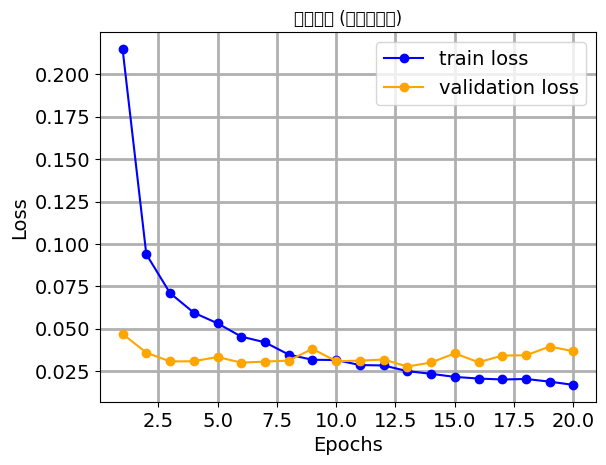

In [18]:
## 学習曲線 (損失関数値)
x = list(range(1, epoch + 1))
train_loss = history["train_loss"]
val_loss = history["validation_loss"]   
plt.figure()
plt.plot(x, train_loss, label='train loss', color='blue', marker='o')
plt.plot(x, val_loss, label='validation loss', color='orange', marker='o')
plt.xlabel('Epochs', size=14)
plt.ylabel('Loss', size=14)
plt.title('学習曲線 (損失関数値)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()
